In [4]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


Rating and Sentiment Score Threshold

In [5]:
import pandas as pd
from textblob import TextBlob

df = pd.read_csv('final_dataset.csv')

combined_rating = df['stars'].mean()

rating_threshold = combined_rating

df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

combined_sentiment_score = df['sentiment_score'].mean()

sentiment_threshold = combined_sentiment_score

df['rule1_threshold'] = df.apply(lambda row: 0 if row['stars'] < rating_threshold and row['sentiment_score'] < sentiment_threshold else 1, axis=1)

df.to_csv('threshold.csv', index=False)

num_filtered_reviews = len(df)
rule_counts = df['rule1_threshold'].value_counts()

print("Count of reviews with rule1_threshold equal to 0 and 1:")
print(rule_counts)
print(f"Rating Threshold: {rating_threshold}")
print(f"Sentiment Score Threshold: {sentiment_threshold}")
print(f"Number of Reviews: {num_filtered_reviews}")


Count of reviews with rule1_threshold equal to 0 and 1:
rule1_threshold
1    41102
0    12358
Name: count, dtype: int64
Rating Threshold: 3.8563973063973065
Sentiment Score Threshold: 0.23259107181563363
Number of Reviews: 53460


Useful Count Threshold Calculation

In [6]:
import pandas as pd

threshold_df = pd.read_csv('threshold.csv')

average_useful = threshold_df['useful'].mean()

threshold = average_useful

threshold_df['rule5_threshold'] = threshold_df['useful'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('threshold.csv', index=False)

above_threshold_count = threshold_df[threshold_df['useful'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['useful'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 2.151889263000374
Number of reviews above threshold: 15213
Number of reviews below threshold: 38247


Average Length Threshold

In [7]:
import pandas as pd

threshold_df = pd.read_csv('threshold.csv')

average_text_length = threshold_df['text'].apply(len).mean()

threshold = average_text_length

threshold_df['rule2_threshold'] = threshold_df['text'].apply(lambda x: 1 if len(x) > threshold else 0)

threshold_df.to_csv('threshold.csv', index=False)

print("Average Text Length:", average_text_length)
print("Threshold Value:", threshold)
print("Number of Reviews Above Threshold:", (threshold_df['rule2_threshold'] == 1).sum())
print("Number of Reviews Below or Equal to Threshold:", (threshold_df['rule2_threshold'] == 0).sum())


Average Text Length: 773.362532734755
Threshold Value: 773.362532734755
Number of Reviews Above Threshold: 20194
Number of Reviews Below or Equal to Threshold: 33266


In [2]:
!python -m spacy download en_core_web_md


     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 388.9 kB/s eta 0:01:50
     --------------------------------------- 0.1/42.8 MB 655.4 kB/s eta 0:01:06
     ---------------------------------------- 0.2/42.8 MB 1.4 MB/s eta 0:00:32
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:31
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB

Rating with Timeframe

In [8]:
import pandas as pd

df = pd.read_csv('threshold.csv')

df['date'] = pd.to_datetime(df['date'])

user_reviews_per_day = df.groupby(['user_id', df['date'].dt.date]).size()

combined_avg_reviews_per_day = user_reviews_per_day.mean()

threshold_reviews_per_day = combined_avg_reviews_per_day

combined_rating = df['stars'].mean()

threshold_rating = combined_rating  

filtered_users = user_reviews_per_day[(user_reviews_per_day > threshold_reviews_per_day)].reset_index()

filtered_reviews = df[df['user_id'].isin(filtered_users['user_id'])]
filtered_reviews = filtered_reviews[filtered_reviews['stars'] < threshold_rating]

df['rule4_threshold'] = 1  
df.loc[df['review_id'].isin(filtered_reviews['review_id']), 'rule4_threshold'] = 0  

df.to_csv('threshold.csv', index=False)

num_filtered_reviews = len(filtered_reviews)
print(f"Reviews per Day Threshold: {threshold_reviews_per_day}")
print(f"Rating Threshold: {threshold_rating}")
print(f"Number of Filtered Reviews: {num_filtered_reviews}")


Reviews per Day Threshold: 1.0884215241158866
Rating Threshold: 3.8563973063973065
Number of Filtered Reviews: 7716


In [9]:
pip install datasketch

Note: you may need to restart the kernel to use updated packages.


Rule 6 : User id, Similarity Score, Time Threshold

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

df = pd.read_csv('threshold.csv')

df['date'] = pd.to_datetime(df['date'])

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

num_perm = 128

lsh = MinHashLSH(threshold=0.7, num_perm=num_perm)

minhashes = []
for i in range(len(df)):
    text = df.iloc[i]['text']
    words = text.split()
    minhash = MinHash(num_perm=num_perm)
    for word in words:
        minhash.update(word.encode('utf-8'))
    lsh.insert(i, minhash)
    minhashes.append(minhash)

def calculate_similarity(row):
    query_text = row['text']
    query_minhash = MinHash(num_perm=num_perm)
    for word in query_text.split():
        query_minhash.update(word.encode('utf-8'))
    
    similar_indices = lsh.query(query_minhash)
    
    similarities = []
    for idx in similar_indices:
        similarities.append(minhashes[idx].jaccard(query_minhash))
    
    return max(similarities)

df['similarity_score'] = df.apply(calculate_similarity, axis=1)

user_similarity = df.groupby('user_id')['similarity_score'].mean()

user_time_difference = df.groupby('user_id')['date'].apply(lambda x: (x.max() - x.min()).total_seconds()).mean()

def calculate_threshold(user_similarity, user_time_difference):
    threshold = user_similarity * user_time_difference
    return threshold

threshold = calculate_threshold(user_similarity.mean(), user_time_difference)

df['rule6_threshold'] = df['similarity_score'].apply(lambda score: 0 if score > threshold else 1)

df.to_csv('threshold.csv', index=False)

print(f'Threshold: {threshold}')
print(f'Number of reviews above threshold: {df[df["rule6_threshold"] == 0].shape[0]}')
print(f'Number of reviews below threshold: {df[df["rule6_threshold"] == 1].shape[0]}')


Threshold: 39720459.39412263
Number of reviews above threshold: 0
Number of reviews below threshold: 53460


Rule 3 Similarity Score within the time frame

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

df = pd.read_csv('threshold.csv')

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

num_perm = 128

lsh = MinHashLSH(threshold=0.7, num_perm=num_perm)

minhashes = []
for i in range(len(df)):
    text = df.iloc[i]['text']
    words = text.split()
    minhash = MinHash(num_perm=num_perm)
    for word in words:
        minhash.update(word.encode('utf-8'))
    lsh.insert(i, minhash)
    minhashes.append(minhash)

similar_reviews_indices = []
for i, minhash in enumerate(minhashes):
    similar_indices = lsh.query(minhash)
    similar_indices = [idx for idx in similar_indices if idx != i]
    for j in similar_indices:
        similar_reviews_indices.append((i, j))

similar_reviews_df = df.iloc[[index for pair in similar_reviews_indices for index in pair]]

df['rule3_threshold'] = df.apply(lambda row: 0 if row.name in similar_reviews_df.index else 1, axis=1)

df.to_csv('threshold.csv', index=False)

num_similar_reviews = len(similar_reviews_df)
print(f"Number of Similar Reviews: {num_similar_reviews}")

Number of Similar Reviews: 372


Adding of target attribute

In [12]:
import pandas as pd

df = pd.read_csv('threshold.csv')

columns_to_check = ['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']

df['count_ones'] = df[columns_to_check].sum(axis=1)

df['target'] = df['count_ones'].apply(lambda x: 'genuine' if x > 3 else 'fake')

df.to_csv('final_dataset.csv', index=False)

No of fake and Genuine

In [13]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

target_counts = df['target'].value_counts()

print("Number of texts labeled as 'genuine':", target_counts['genuine'])
print("Number of texts labeled as 'fake':", target_counts['fake'])


Number of texts labeled as 'genuine': 44847
Number of texts labeled as 'fake': 8613


Sarcasam Detection

In [14]:
import pandas as pd

threshold_df = pd.read_csv('final_dataset.csv')

average_useful = threshold_df['funny'].mean()

threshold = average_useful

threshold_df['funny_threshold'] = threshold_df['funny'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('final_dataset.csv', index=False)

above_threshold_count = threshold_df[threshold_df['funny'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['funny'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 0.8245604190048634
Number of reviews above threshold: 17714
Number of reviews below threshold: 35746


In [15]:
import pandas as pd

threshold_df = pd.read_csv('final_dataset.csv')

average_useful = threshold_df['stars'].mean()

threshold = average_useful

threshold_df['star_threshold'] = threshold_df['stars'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('final_dataset.csv', index=False)

above_threshold_count = threshold_df[threshold_df['stars'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['stars'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 3.8563973063973065
Number of reviews above threshold: 37313
Number of reviews below threshold: 16147


In [16]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

filtered_reviews = df[(df['funny_threshold'] == 1) & (df['star_threshold'] == 0) & (df['sentiment_score'] > 0) & (df['target'] == 'genuine')]

num_reviews = filtered_reviews.shape[0]

df.loc[filtered_reviews.index, 'target'] = 'fake'

df.to_csv('final_dataset.csv', index=False)

print("Number of reviews that meet the specified conditions:", num_reviews)


Number of reviews that meet the specified conditions: 2902


In [17]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

target_counts = df['target'].value_counts()

print("Number of texts labeled as 'genuine':", target_counts['genuine'])
print("Number of texts labeled as 'fake':", target_counts['fake'])


Number of texts labeled as 'genuine': 41945
Number of texts labeled as 'fake': 11515


In [18]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

df.to_csv('test.csv', index=False)


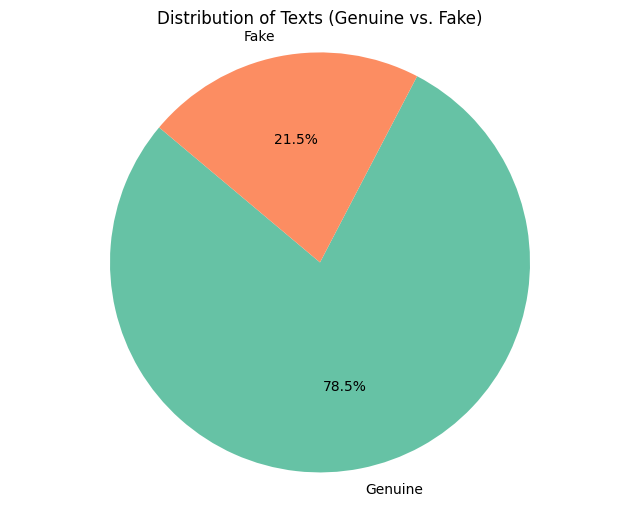

In [2]:
import matplotlib.pyplot as plt

# Data
labels = ['Genuine', 'Fake']
sizes = [41945, 11515]
colors = ['#66c2a5', '#fc8d62']  # Attractive colors

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Texts (Genuine vs. Fake)')
plt.show()


In [4]:
pip install fuzzy-c-means


Note: you may need to restart the kernel to use updated packages.


FUZZY


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM

# Load the processed dataset
df = pd.read_csv('threshold.csv')

# Define the threshold conditions for genuine reviews
genuine_thresholds = {
    'rule1_threshold': 1,  # RULE 1 above threshold
    'rule2_threshold': 1,  # RULE 2 above threshold
    'rule3_threshold': 0,  # RULE 3 below threshold
    'rule4_threshold': 0,  # RULE 4 below threshold
    'rule5_threshold': 1,  # RULE 5 above threshold
    'rule6_threshold': 0   # RULE 6 below threshold
}

# Select rule threshold columns as features
features = df[['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define the number of clusters
c = 2  # Binary clustering with genuine and fake clusters

# Perform Fuzzy C-Means clustering
fcm = FCM(n_clusters=c, m=2.0)
fcm.fit(features_scaled)

# Get the cluster centers and membership values
cntr = fcm.centers
u = fcm.u

# Determine which cluster represents genuine and fake reviews
genuine_cluster = np.argmax(cntr[0])  # Assume the first cluster represents genuine reviews
fake_cluster = 1 - genuine_cluster

# Determine the binary cluster membership based on the threshold conditions
cluster_membership_binary = []
for i in range(len(df)):
    num_rules_met = sum([1 for rule, threshold in genuine_thresholds.items() if df.at[i, rule] == threshold])
    is_genuine = num_rules_met >= 4
    cluster_membership_binary.append(int(is_genuine))

# Add the binary cluster membership to the dataframe
df['binary_cluster'] = cluster_membership_binary

# Count genuine and fake reviews
genuine_count = df['binary_cluster'].sum()
fake_count = len(df) - genuine_count

# Save the results to a CSV file
df.to_csv('binary_clusters.csv', index=False)

# Print the results
print("Cluster Centers:")
print(cntr)
print(f"Number of genuine reviews: {genuine_count}")
print(f"Number of fake reviews: {fake_count}")


Cluster Centers:
[[ 0.32410924 -0.55332281  0.02745265  0.24311494 -0.4533088   0.        ]
 [-0.30077147  0.72255568 -0.00765622 -0.20560341  0.63553415  0.        ]]
Number of genuine reviews: 210
Number of fake reviews: 53250
